In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import pytorch_lightning as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule, DimmedSDOMLDataModule
from sdofm.pretraining import FBHMSIMAE

In [3]:
import omegaconf

cfg = omegaconf.OmegaConf.load("../experiments/pretrain_tiny_mae.yaml")

In [70]:
data_module = SDOMLDataModule(
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.cache
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [71]:
model = FBHMSIMAE(
    **cfg.model.mae,
    **cfg.model.samae,
    hmi_mask=data_module.hmi_mask,
    optimiser=cfg.model.opt.optimiser,
    lr=cfg.model.opt.learning_rate,
    weight_decay=cfg.model.opt.weight_decay,
)

In [72]:
trainer = pl.Trainer(
    devices=1, accelerator=cfg.experiment.accelerator, max_epochs=cfg.model.opt.epochs
)
trainer.fit(model=model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/sdofm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type                                                      | Params
------------------------------------------------------------------------------------------
0 | autoencoder | FlareBaisedHMIMaskedSingleIntensityMaskedAutoencoderViT3D | 4.0 M 
-------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 5, got 4)

In [47]:
rbg_image_batch = next(iter(data_module.train_dataloader()))

In [49]:
rbg_image_batch.shape

torch.Size([1, 9, 3, 512, 512])

In [81]:
single_image_batch = next(iter(data_module.train_dataloader()))

10927322498  498832503  677932501  6777542227627
32498 11390341797 

 33040 9778130525228386669439646 
 55606  33038  798443182951718 3391866693 8628 55604  31732  3303653466 339163540966691 8626  3964455602
 101703182753464 
  
35407 
86248125 10168 2157933914
53462 31825 85310 




1016564217 

3540434475
 

 
47612 3653339642

2901834473 
 47609 36532
 34471  
4762329015
36530
 

29014


109273 4988 6779 6777

41797 113903 6669455606  5560466693  55602

66691

79844 53466 228383052553464   86283391853462 
 8626
3391631732   2157986241017033914 

 34475

10168  344731016554222
  
34471224983304097781
   
8125330383250331829    47612325013303631827  
 
324984760931825

 
47623


85310 36533 36532 36530

51718 35409 35407 35404

642177627  3964629018  3964429015  3964229014



109273 4988 6779 6777

41797 66694 66693 66691

22838 33918 33916 33914

31732 10170 10168 10165

54222 33040 33038 33036

3052579844  534668628  534648626  53462
8624


113903 81259778155606   476123182955604   

In [85]:
data_module.aligndata.iloc[0].name

Timestamp('2010-05-13 00:00:00')

In [106]:
single_image_batch.shape

torch.Size([1, 9, 1, 512, 512])

In [109]:
patchified = model.autoencoder.patchify(
    single_image_batch
)  # pre single channel = torch.Size([1, 3072, 2304])
patchified.shape

torch.Size([1, 1024, 2304])

In [107]:
# from einops import rearrange
# p = patch_embed.patch_size[0]
# tub = patch_embed.tubelet_size
# x = rearrange(
#     single_image_batch, "b c (h p) (w q) -> b (h w) (4 p q c)", p=p, q=p
# )
# x.shape

In [97]:
patch_embed.tubelet_size

1

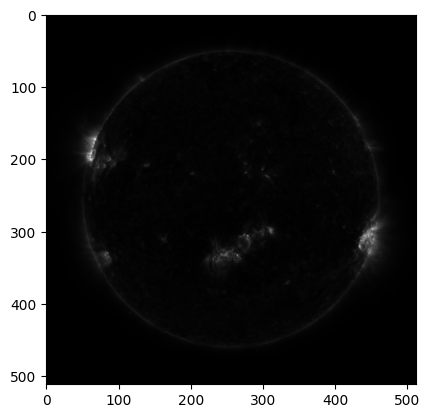

In [7]:
import matplotlib.pyplot as plt

plt.imshow(image_batch[0, 0, 0, :, :].cpu().numpy(), cmap="gray")

torch.Size([512, 512])


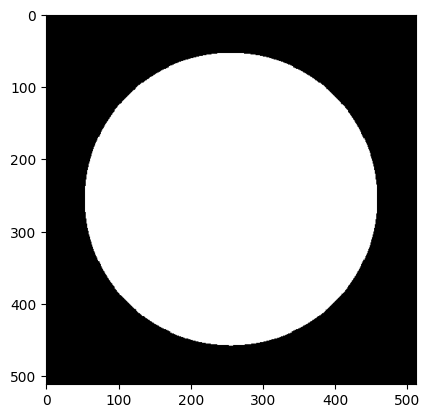

In [19]:
mask = data_module.hmi_mask
print(mask.shape)
plt.imshow(mask.cpu().numpy(), cmap="gray")

In [94]:
from sdofm.utils import get_1d_sincos_pos_embed_from_grid, get_3d_sincos_pos_embed

embed_dim = 128
num_frames = 1
tubelet_size = 1
img_size = (512, 512)
patch_size = (16, 16)
grid_size = (
    num_frames // tubelet_size,
    img_size[0] // patch_size[0],
    img_size[1] // patch_size[1],
)
num_patches = grid_size[0] * grid_size[1] * grid_size[2]
pos_embed_zeros = torch.zeros(1, num_patches + 1, embed_dim)
pos_embed = get_3d_sincos_pos_embed(
    pos_embed_zeros.shape[-1], grid_size, cls_token=False
)

In [149]:
single_image_batch.shape

torch.Size([1, 9, 1, 512, 512])

In [169]:
mask.shape
a = np.repeat(mask[:, :, np.newaxis], 9, axis=2)
b = np.repeat(a[:, :, :, np.newaxis], 1, axis=3)
c = np.repeat(b[:, :, :, :, np.newaxis], 1, axis=4)
# c.shape
d = torch.Tensor(np.transpose(c, axes=(3, 2, 4, 0, 1))).to(dtype=torch.float)

In [155]:
mask.shape

torch.Size([512, 512])

In [165]:
single_image_batch[0, 0]

tensor([[[-0.6483, -0.6483, -0.6483,  ..., -0.6483, -0.6483, -0.6483],
         [-0.6483, -0.6483, -0.6483,  ..., -0.6483, -0.6483, -0.6483],
         [-0.6483, -0.6483, -0.6483,  ..., -0.6483, -0.6483, -0.6483],
         ...,
         [-0.6483, -0.6483, -0.6483,  ..., -0.6483, -0.6483, -0.6483],
         [-0.6483, -0.6483, -0.6483,  ..., -0.6483, -0.6483, -0.6483],
         [-0.6483, -0.6483, -0.6483,  ..., -0.6483, -0.6483, -0.6483]]])

In [172]:
patch_embed = PatchEmbed(512, 16, 1, 1, 9, 128, flatten=True)
x = patch_embed(d)
x.shape

input dim torch.Size([1, 9, 1, 512, 512])
proj dim torch.Size([1, 128, 1, 32, 32])


torch.Size([1, 1024, 128])

In [189]:
indices = np.arange(32 * 32).reshape(32, 32).astype(np.int64)
ai = np.repeat(indices[:, :, np.newaxis], 128, axis=2)
bi = np.repeat(ai[:, :, :, np.newaxis], 1, axis=3)
ci = np.repeat(bi[:, :, :, :, np.newaxis], 1, axis=4)
di = torch.Tensor(np.transpose(ci, axes=(3, 2, 4, 0, 1)))  # .to(dtype=torch.float)
di.shape
fi = di.flatten(2).transpose(1, 2)
fi.shape

torch.Size([1, 1024, 128])

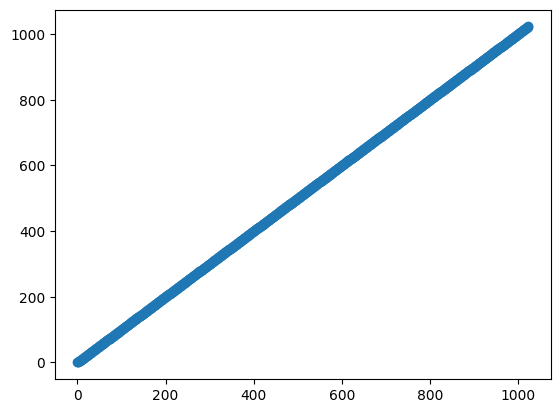

In [196]:
plt.scatter(x=range(1024), y=fi[0, :, 0].detach().numpy())

In [200]:
15 * 15

225

In [199]:
fi[0, :, 0].max()

tensor(1023.)

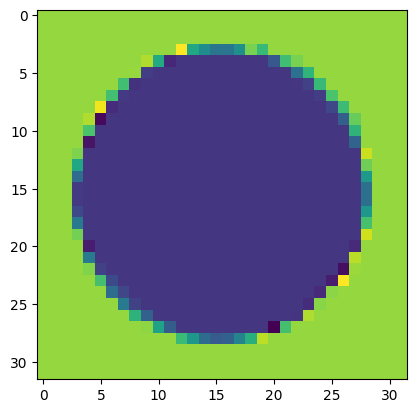

In [171]:
plt.imshow(x[0, 0, 0, :, :].detach().numpy())

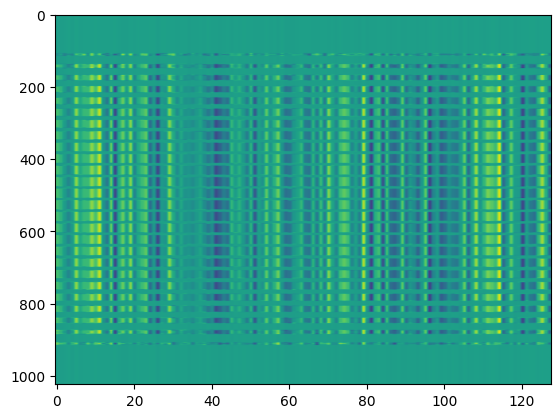

In [175]:
plt.imshow(x[0, :, :].detach().numpy(), aspect="auto")

In [ ]:
pos_embed = get_3d_sincos_pos_embed(
    pos_embed.shape[-1], patch_embed.grid_size, cls_token=False
)
pos_embed = torch.from_numpy(pos_embed).float().unsqueeze(0)
pos_embed.shape

torch.Size([1, 1024, 128])

In [132]:
patchified.shape

torch.Size([1, 1024, 2304])

In [292]:
patch_embed.grid_size[1]

32

In [221]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.data.sample
import sunpy.map
from sunpy.coordinates.frames import HeliographicStonyhurst

aiamap = sunpy.map.Map(
    sunpy.data.sample.AIA_171_IMAGE
)  # example image is loaded at 1024x1024


def stonyhurst_to_patch_index(lat, lon):
    # Heliographic Stonyhurst coordinates to patch index
    # lat, lon = 15.73, 0
    coord = SkyCoord(lat * u.deg, lon * u.deg, frame=HeliographicStonyhurst)
    x, y = aiamap.wcs.world_to_pixel(coord)  # (x, y) in pixels
    x, y = x / 2 // patch_embed.patch_size[0], y / 2 // patch_embed.patch_size[0]
    return np.array([x, y])

In [310]:
middle_patch = stonyhurst_to_patch_index(0, 0)
middle_patch

array([15., 15.])

In [302]:
r1_patch = stonyhurst_to_patch_index(0, -60)[1]
r2_patch = stonyhurst_to_patch_index(0, 60)[1]

In [335]:
stonyhurst_to_patch_index(60, 0)
# r2_patch = stonyhurst_to_patch_index(0, 60)[1]

array([26., 15.])

In [236]:
mean_patch = (
    abs(
        (stonyhurst_to_patch_index(15.73, 0) - stonyhurst_to_patch_index(0, 0))
        + abs(stonyhurst_to_patch_index(-15.73, 0) - stonyhurst_to_patch_index(0, 0))
    )
)[0] / 2
mean_patch

3.5

In [230]:
std_patch = (stonyhurst_to_patch_index(6.14, 0) - stonyhurst_to_patch_index(0, 0))[0]
std_patch

2.0

In [355]:
# torch.uniform(0, 32)
# x = torch.distributions.uniform.Uniform(0,32).sample((1024,))
# x

# get uniform random numbers between [r1_patch, r2_patch]
# (r1 - r2) * torch.rand(a, b) + r2
# random_lons = torch.floor( (r1_patch - r2_patch ) * torch.rand((1024,)) + r2_patch ).to(dtype=torch.uint8)
N = 2
random_lons = torch.floor((r1_patch - r2_patch) * torch.rand((N, 1024)) + r2_patch).to(
    dtype=torch.uint8
)

In [356]:
normal_lats = torch.floor(torch.normal(mean_patch, std_patch, size=(N, 1024)))

In [357]:
random_hemisphere = torch.floor(torch.rand((N, 1024)) * (2)).to(dtype=torch.int8)
random_hemisphere[random_hemisphere == 0] = -1
random_lats = random_hemisphere * normal_lats

In [358]:
random_lons.shape

torch.Size([2, 1024])

Text(0, 0.5, 'Patch index (solar latitude)')

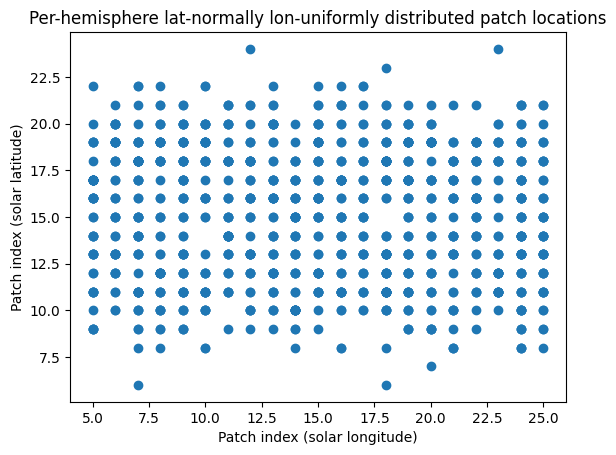

In [359]:
plt.scatter(random_lons[0, :], random_lats[0, :] + 15)
plt.title("Per-hemisphere lat-normally lon-uniformly distributed patch locations")
plt.xlabel("Patch index (solar longitude)")
plt.ylabel("Patch index (solar latitude)")

In [312]:
N = 1
L = 1024
noise = torch.rand(N, L)  # noise in [0, 1]

# sort noise for each sample
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=1)

In [332]:
ids_shuffle = random_lons * (random_lats + 15)
ids_shuffle.to(dtype=torch.int16)

tensor([[288, 105, 119,  ..., 285,  78, 304],
        [119, 264, 380,  ..., 216,  70, 162]], dtype=torch.int16)

In [333]:
torch.argsort(ids_shuffle, dim=1)

tensor([[  36,  297,  606,  ..., 1004,   63,  370],
        [ 647,  720,  372,  ...,   50,  479,  785]])

In [315]:
ids_shuffle

tensor(1023)

In [289]:
32 * 32

1024

In [216]:
15 - 12
19 - 15
# patch_idx = x*y

# Patch index to embedding index
# frame_number

4

In [210]:
torch.normal(3.5)

2048

In [203]:
import numpy as np

# Patch number to embedding index
indices = np.arange(32 * 32).reshape(32, 32).astype(np.int64)
ai = np.repeat(indices[:, :, np.newaxis], 128, axis=2)
bi = np.repeat(ai[:, :, :, np.newaxis], 1, axis=3)
ci = np.repeat(bi[:, :, :, :, np.newaxis], 1, axis=4)
di = torch.Tensor(np.transpose(ci, axes=(3, 2, 4, 0, 1)))  # .to(dtype=torch.float)
di.shape
fi = di.flatten(2).transpose(1, 2)
fi.shape

(15.0, 15.0)

In [208]:
torch.where(fi[0, :, 0] == patch_idx)

(tensor([225]),)

In [136]:
p = patch_embed.patch_size[0]
num_p = patch_embed.img_size[0] // p
tub = patch_embed.tubelet_size
imgs = rearrange(
    pos_embed,
    "b (t h w) (tub p q c) -> b c (t tub) (h p) (w q)",
    h=num_p,
    w=num_p,
    tub=tub,
    p=p,
    q=p,
)

EinopsError:  Error while processing rearrange-reduction pattern "b (t h w) (tub p q c) -> b c (t tub) (h p) (w q)".
 Input tensor shape: torch.Size([1, 1024, 128]). Additional info: {'h': 32, 'w': 32, 'tub': 1, 'p': 16, 'q': 16}.
 Shape mismatch, can't divide axis of length 128 in chunks of 256

In [137]:
num_p

32

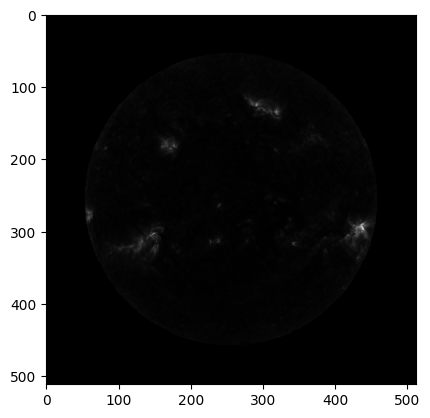

In [101]:
plt.imshow(imgs[0, 0, 0, :, :].cpu().numpy(), cmap="gray")

In [40]:
import numpy as np

b = np.repeat(mask[:, :, np.newaxis], 4, axis=2)
b = np.transpose(b, axes=[2, 0, 1])
(b[0, :, :] == b[1, :, :])

tensor(True)

In [12]:
from sdofm.models.samae3d import PatchEmbed

patch_embed = PatchEmbed(512, 16, 1, 1, 9, 128, flatten=False)

nn.Conv3d(
    in_chans=3,
    embed_dim=128,
    kernel_size=(1, 16, 16),
    stride=(1, 16, 16),
    bias=True,
)

In [13]:
patch_embed(image_batch).shape

input dim torch.Size([1, 9, 3, 512, 512])
proj dim torch.Size([1, 128, 3, 32, 32])


torch.Size([1, 128, 3, 32, 32])

In [16]:
patch_embed.proj.weight.shape

torch.Size([128, 9, 1, 16, 16])

In [17]:
16 * 32

512

The MaskedConv3D is a standard Conv3D with a binary mask applied on sampling locations that shouldn't contribute to the learning process. Whilst in theory a Conv3D could be written to take non-cubic input voxels this should achieve the same effect. The standard torch `nn.Conv3d` is modified such that 

In the simplest case, the output value of the layer with input size $(N, C_{in},D,H,W)$, output $(N, C_{out},D_{out},H_{out},W_{out})$, and logical mask $M$ can be described as:

$$out(N_i, C_{out_j}) = bias(C_{out_j})+ \sum_{C_{in}-1}^{k=0} M*weight(C_{out_j}, k) \star input(N_i, k)$$